# Initialisation

In [90]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import scipy.linalg as lin
import scipy.sparse as sp
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

from tqdm import tqdm

from Ising import *
from Ising3D import *
from plot_tools import *
from Newton import Newton

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 2-D Ising model

In [33]:
Nx,Ny = 5,5

g = 1
beta = 10

config = random_lattice(Nx,Ny)

i,j = np.random.randint(low=0,high=Nx),np.random.randint(low=0,high=Ny)

config_flip = np.copy(config)
config_flip[i,j] *= -1

dE = calcEnergy(config_flip,Nx,Ny,g)[0] - calcEnergy(config,Nx,Ny,g)[0]

dE2 = delta_energy_flip(config,i,j,Nx,Ny,g)

print(dE,dE2)

-4 -4


## Magnetisation

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:02<00:00,  3.53it/s]


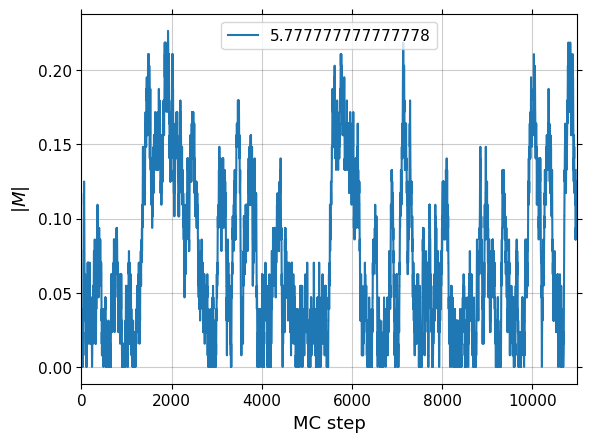

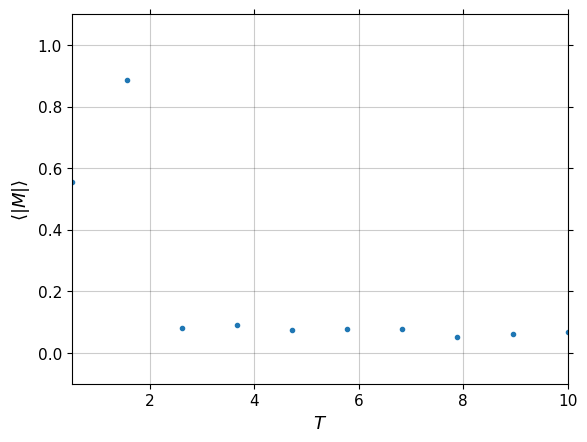

In [34]:
Nx, Ny = 16, 16 # size of the lattice
g = 1

Neq = 1000 # number of MC steps for equilibrium
Nsteps = 10000 # number of MC sample for average

T = np.linspace(0.5,10,10)
M = np.zeros(len(T))

create_plot('MC step',r'$|M|$',[0,Nsteps+Neq])

for i in tqdm(range(len(T))) :

    t = T[i]
    M_burnin = np.zeros(Neq+Nsteps)
    config = random_lattice(Nx,Ny)


    # reach equilibrium
    for j in range(Neq) :
        config = MC_step(config,Nx,Ny,g,1/t)[0]
        M_burnin[j] = np.abs(mag(config))/(Nx*Ny)
    
        
    # sample for average
    Mt = np.zeros(Nsteps)

    for k in range(Nsteps) :
        config = MC_step(config,Nx,Ny,g,1/t)[0]
        Mt[k] = np.abs(mag(config))
        M_burnin[Neq+k] = np.abs(mag(config))/(Nx*Ny)

    #if i==1 or i==25 or i==50 or i==99 : plot_lattice(config,Nx,Ny)

    M[i] = np.sum(Mt)/(Nsteps*Nx*Ny)
    if i == 5 :plt.plot(range(Neq+Nsteps),M_burnin,label=str(t))
    
plt.legend()

Tc = 2*g/np.log(1+np.sqrt(2))
create_plot(r'$T$',r'$\langle |M|\rangle$',[T[0],T[-1]],ylim=[-0.1,1.1])
plt.plot(T,M,'.')  

plt.show()      

In [35]:
print(Tc)

2.269185314213022


# 3-D Ising

In [36]:
Nx,Ny,Nz = 3,3,3

J = 1
Gamma = 1
beta = 10

config = random_lattice3D(Nx,Ny,Nz)

i,j,k = np.random.randint(low=0,high=Nx),np.random.randint(low=0,high=Ny),np.random.randint(low=0,high=Nz)

config_flip = np.copy(config)
config_flip[i,j,k] *= -1

E = energy3D(config_flip,J,Gamma,beta)

E2 = energy3D(config,J,Gamma,beta) + delta_energy_flip3D(config,i,j,k,J,Gamma,beta)

print(E,E2)


-3.3298972202146757 -3.330915327805389


## Magnetisation

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [05:08<00:00, 12.36s/it]


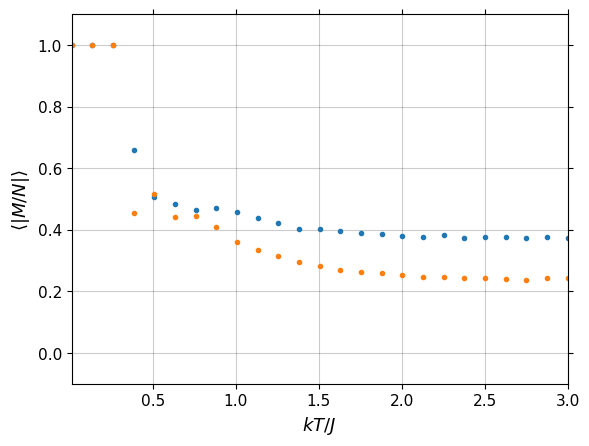

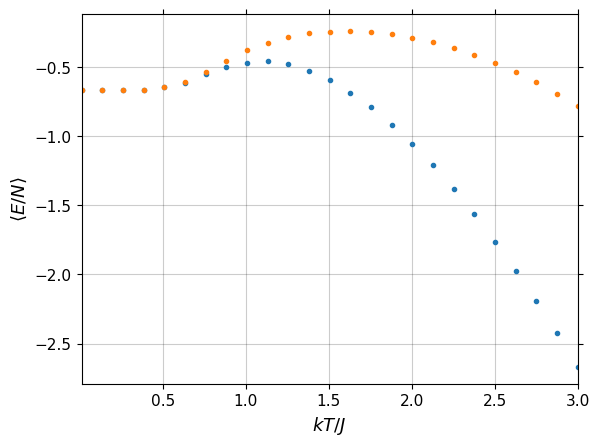

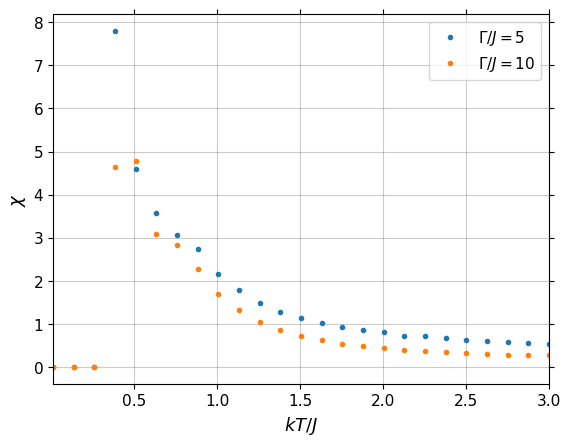

In [37]:
Nx, Ny, Nz = 3, 3, 3 # size of the lattice
J = 1

Neq = 5000 # number of MC steps for equilibrium
Nsteps = 500000 # number of MC sample for average

T = np.linspace(0.01,3,25)
Gamma = [5,10]

M,E,chi = MC_averages(Nx, Ny, Nz, J, Gamma, T, Neq, Nsteps, plot_MC = [])

create_plot(r'$kT/J$',r'$\langle |M/N|\rangle$',[T[0]/J,T[-1]/J],ylim=[-0.1,1.1])
for i,gamma in enumerate(Gamma) :
    plt.plot(T/J,M[i,:],'.',label=r'$\Gamma/J=$'+str(gamma))

create_plot(r'$kT/J$',r'$\langle E/N\rangle$',[T[0]/J,T[-1]/J])
for i,gamma in enumerate(Gamma) :
    plt.plot(T/J,E[i,:],'.',label=r'$\Gamma/J=$'+str(gamma))

create_plot(r'$kT/J$',r'$\chi$',[T[0]/J,T[-1]/J])
for i,gamma in enumerate(Gamma) :
    plt.plot(T/J,chi[i,:],'.',label=r'$\Gamma/J=$'+str(gamma))

plt.legend()
plt.show()


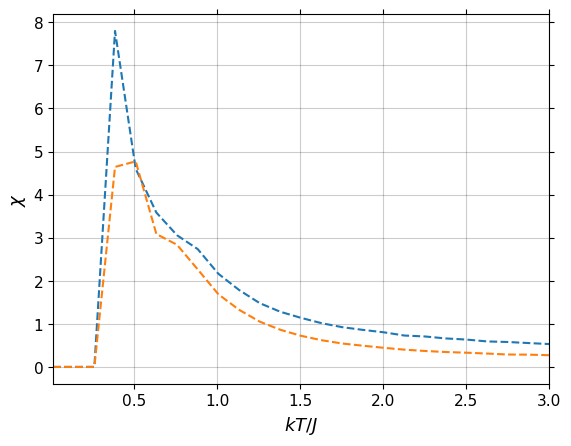

In [39]:
create_plot(r'$kT/J$',r'$\chi$',[T[0]/J,T[-1]/J])
for i,gamma in enumerate(Gamma) :
    plt.plot(T/J,chi[i,:],'--',label=r'$\Gamma/J=$'+str(gamma))

## $N_z \to \infty$ extrapolation

Nz =  4


  0%|          | 0/25 [00:00<?, ?it/s]

  4%|▍         | 1/25 [00:44<17:54, 44.77s/it]


KeyboardInterrupt: 

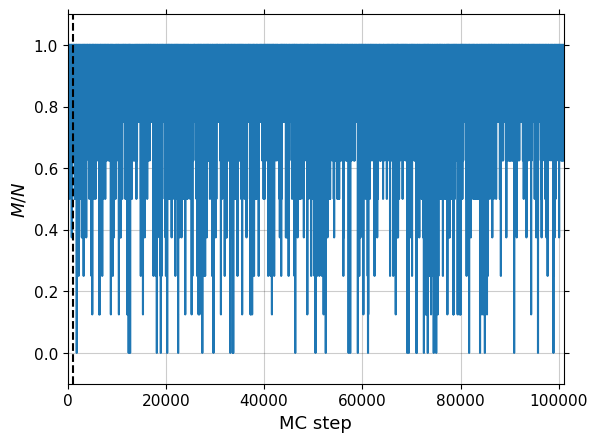

In [145]:
Nx, Ny, Nz = 2, 2, [4,8,12] # size of the lattice
J = 1

Neq = 1000 # number of MC steps for equilibrium
Nsteps = 10000 # number of MC sample for average

T = np.linspace(1,10,20)
Gamma = [1.]

chi = np.zeros((len(Nz),len(T)))
M = np.zeros((len(Nz),len(T)))

for i,nz in enumerate(Nz) :
    print('Nz = ', nz)
    MNz,chiNz = MC_averages(Nx, Ny, nz, J, Gamma, T, Neq, Nsteps, plot_MC = [])
    chi[i] = chiNz[0]
    M[i] = MNz[0]

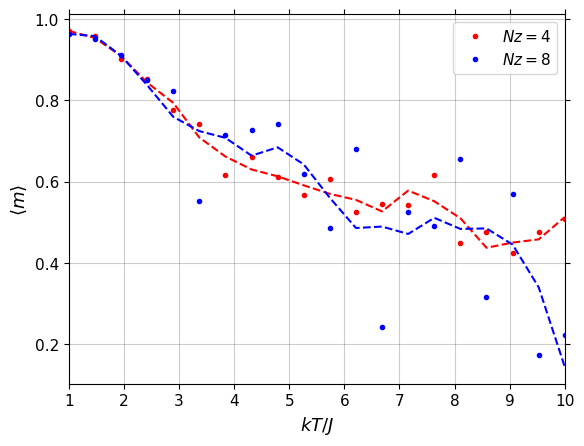

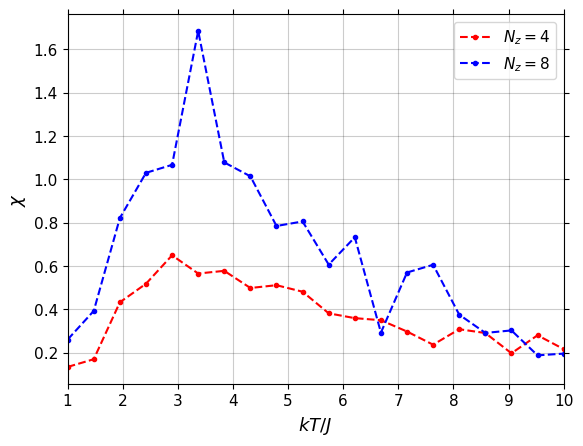

In [139]:
create_plot(r'$kT/J$',r'$\langle m\rangle$',[T[0]/J,T[-1]/J])

colors = ['r','b','g','o']

filters = np.array([[5,3],[9,3],[15,3]])

for i,nz in enumerate(Nz[:-1]) :
    fit = savgol_filter(M[i,:],filters[i,0],filters[i,1])
    plt.plot(T,fit,'--',color=colors[i])
    plt.plot(T,M[i,:],'.',label=r'$Nz=$'+str(nz),color=colors[i])

    plt.legend()

create_plot(r'$kT/J$',r'$\chi$',[T[0]/J,T[-1]/J])

colors = ['r','b','g','o']

filters = np.array([[5,3],[5,3],[15,3]])

for i,nz in enumerate(Nz[:-1]) :
    fit = savgol_filter(chi[i,:],filters[i,0],filters[i,1])
    #plt.plot(T,fit,'--',color=colors[i])
    plt.plot(T,chi[i,:],'--',label=r'$N_z=$'+str(nz),color=colors[i],marker='.')

    plt.legend()

plt.savefig('Report/Plots/T_transition_chi_nz.pdf')

plt.show()

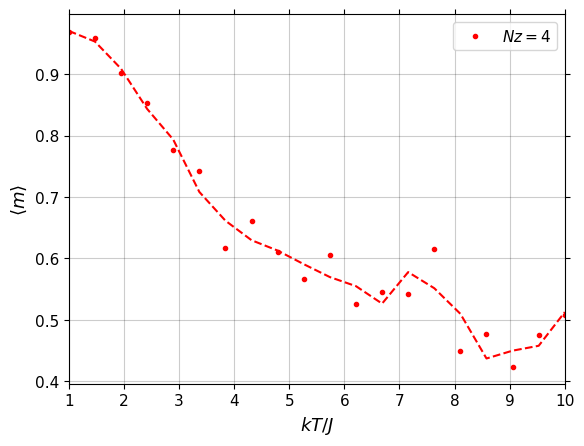

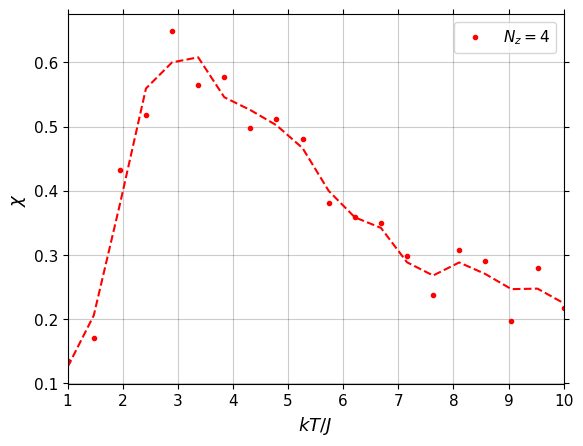

In [141]:
create_plot(r'$kT/J$',r'$\langle m\rangle$',[T[0]/J,T[-1]/J])

colors = ['r','b','g','o']

filters = np.array([[5,3],[9,3],[15,3]])

for i,nz in enumerate(Nz[:-2]) :
    fit = savgol_filter(M[i,:],filters[i,0],filters[i,1])
    plt.plot(T,fit,'--',color=colors[i])
    plt.plot(T,M[i,:],'.',label=r'$Nz=$'+str(nz),color=colors[i])

    plt.legend()

plt.savefig('Report/Plots/T_transition_m.pdf')

create_plot(r'$kT/J$',r'$\chi$',[T[0]/J,T[-1]/J])

colors = ['r','b','g','o']

filters = np.array([[5,3],[5,3],[15,3]])

for i,nz in enumerate(Nz[:-2]) :
    fit = savgol_filter(chi[i,:],filters[i,0],filters[i,1])
    plt.plot(T,fit,'--',color=colors[i])
    plt.plot(T,chi[i,:],'.',label=r'$N_z=$'+str(nz),color=colors[i])

    plt.legend()

plt.savefig('Report/Plots/T_transition_chi.pdf')

plt.show()

## $T\to 0$ extrapolation

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [04:21<00:00, 10.46s/it]


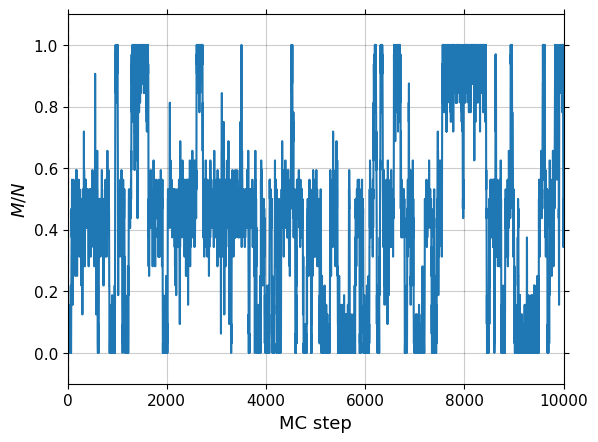

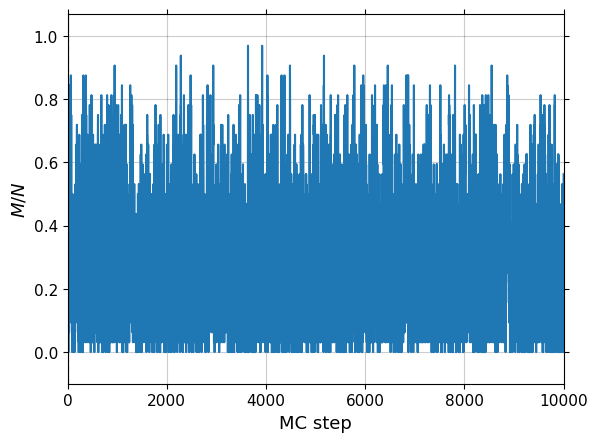

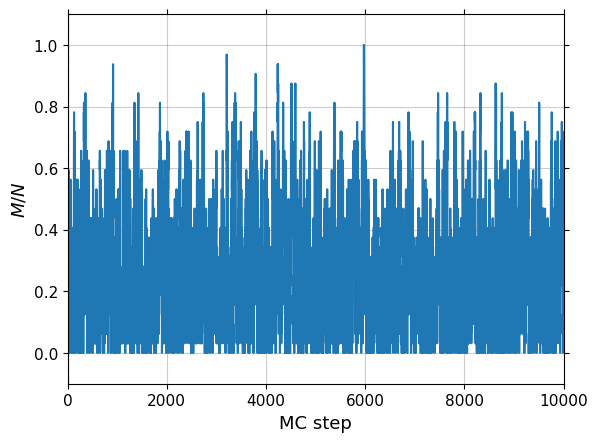

In [167]:
Nx, Ny, Nz = 4, 4, 10 # size of the lattice
J = 1

Neq = 500 # number of MC steps for equilibrium
Nsteps = 10000 # number of MC sample for average

T = [0.5,1.,5]
Gamma = np.linspace(0.1,10,25)


M,chi = MC_averages2(Nx, Ny, nz, J, Gamma, T, Neq, Nsteps, plot_MC = [len(Gamma)//2])

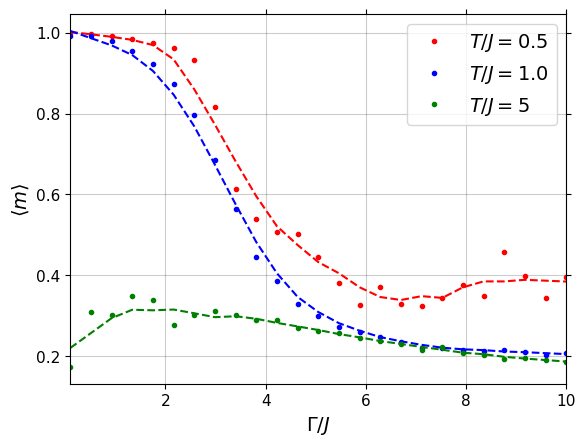

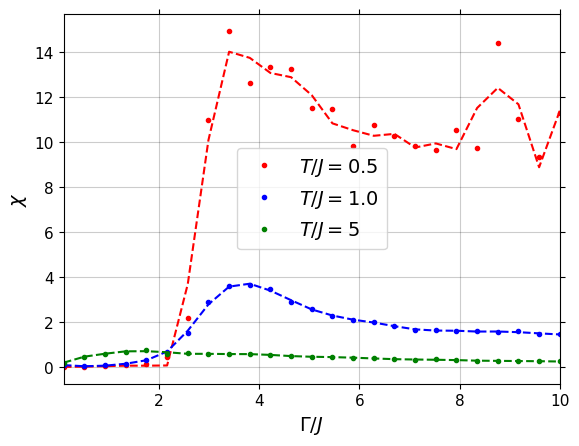

In [168]:
# Plot Mag

create_plot(r'$\Gamma/J$',r'$\langle m\rangle$',[Gamma[0],Gamma[-1]],legend_size=14,axis_size=14)

Gamma_interp = np.linspace(0,Gamma[-1],1000)

colors = ['r','b','g','o']

for i,t in enumerate(T):

    fit = savgol_filter(M[i,:],5,1)
    plt.plot(Gamma,fit,'--',color=colors[i])
    plt.plot(Gamma,M[i,:],'.',label=r'$T/J=$'+str(t),color=colors[i])

    plt.legend()

plt.savefig('Report/Plots/gamma_transition_m_T.pdf')

# Plot chi

create_plot(r'$\Gamma/J$',r'$\chi$',[Gamma[0],Gamma[-1]],legend_size=14,axis_size=14)

Gamma_interp = np.linspace(0,Gamma[-1],1000)

colors = ['r','b','g','o']

for i,t in enumerate(T) :
    fit = savgol_filter(chi[i,:],5,3)
    plt.plot(Gamma,fit,'--',color=colors[i])
    plt.plot(Gamma,chi[i,:],'.',label=r'$T/J=$'+str(t),color=colors[i])

    plt.legend()

plt.savefig('Report/Plots/gamma_transition_chi_T.pdf')

plt.show()

## Phase transition

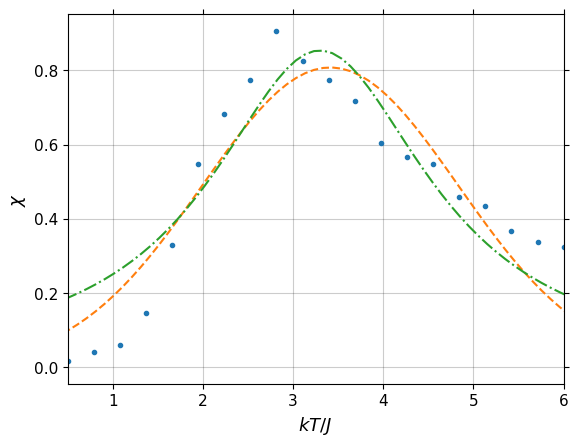

In [14]:
def gauss_fit(T, Tc, sigma, C) :
    return C*np.exp(-(T-Tc)**2/sigma**2)

def lorentz_fit(T, Tc, sigma, C) :
    return C/(1+(T-Tc)**2/sigma**2)


chi = chi[0]

Tc1,sigma1,C1 = curve_fit(gauss_fit,T/J,chi)[0]
Tc2,sigma2,C2 = curve_fit(lorentz_fit,T/J,chi)[0]


create_plot(r'$kT/J$',r'$\chi$',[T[0]/J,T[-1]/J])
plt.plot(T/J,chi,'.')

Tfit = np.linspace(0,10,100)

plt.plot(Tfit,gauss_fit(Tfit,Tc1,sigma1,C1),'--')
plt.plot(Tfit,lorentz_fit(Tfit,Tc2,sigma2,C2),'-.')


plt.show()

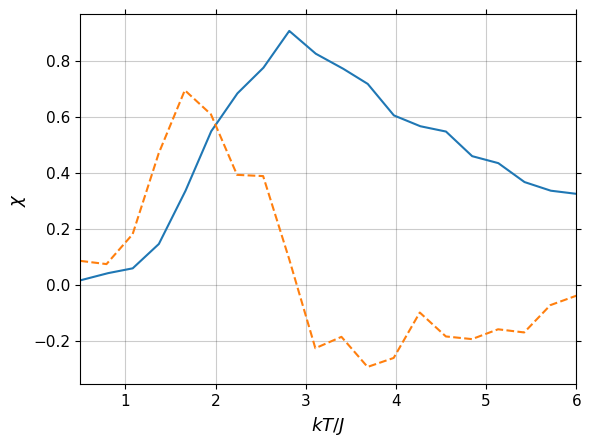

In [33]:
def derivative(f,x,dx=1e-3):
    
    f_plus_dx = interp1d(x,f,fill_value='extrapolate')(x+dx)
    f_minus_dx = interp1d(x,f,fill_value='extrapolate')(x-dx)

    return ((f_plus_dx-f_minus_dx)/(2*dx))

Tfit = np.linspace(0,6,10000)
chi_interp = np.interp(Tfit,T,chi)

dchi = derivative(chi,T)

create_plot(r'$kT/J$',r'$\chi$',[T[0]/J,T[-1]/J])

plt.plot(Tfit/J,chi_interp,'-')

#create_plot(r'$kT/J$',r'$\mathrm{d}\chi/\mathrm{d}T$',[T[0]/J,T[-1]/J])
plt.plot(T,dchi,'--')

plt.show()

## Finite temperature transition

In [158]:
Nx, Ny, Nz = 3, 3, [4] # size of the lattice
J = 1

Neq = 1000 # number of MC steps for equilibrium
Nsteps = 10000 # number of MC sample for average

T = np.linspace(0.1,10,25)
Gamma = [1.]

chi = np.zeros((len(Nz),len(T)))
M = np.zeros((len(Nz),len(T)))

for i,nz in enumerate(Nz) :
    print('Nz = ', nz)
    MNz,chiNz = MC_averages(Nx, Ny, nz, J, Gamma, T, Neq, Nsteps, plot_MC = [])
    chi[i] = chiNz[0]
    M[i] = MNz[0]

Nz =  4


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [02:27<00:00,  5.89s/it]


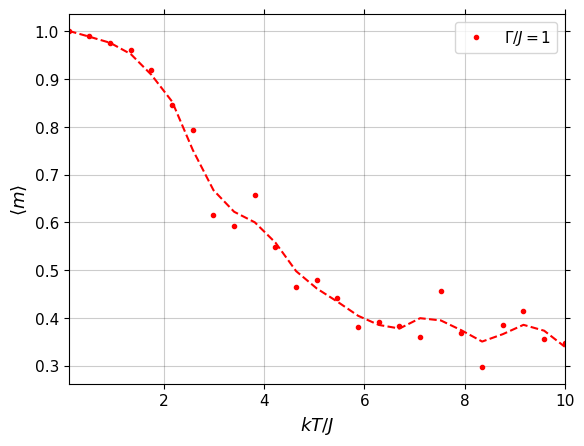

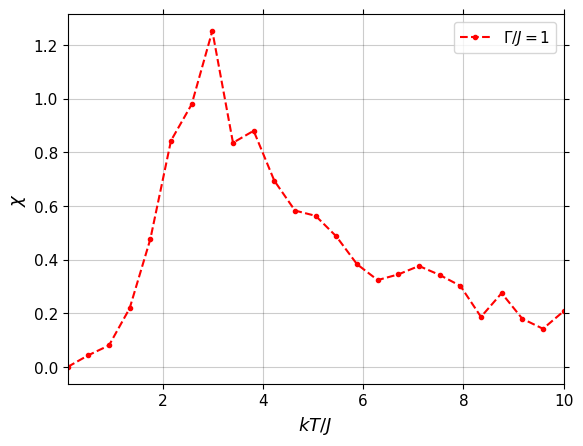

In [164]:
create_plot(r'$kT/J$',r'$\langle m\rangle$',[T[0]/J,T[-1]/J])

colors = ['r','b','g','o']

filters = np.array([[3,1],[9,3],[15,3]])

for i,nz in enumerate(Nz) :
    fit = savgol_filter(M[i,:],filters[i,0],filters[i,1])
    plt.plot(T,fit,'--',color=colors[i])
    plt.plot(T,M[i,:],'.',label=r'$\Gamma/J=$'+str(1),color=colors[i])

    plt.legend()

plt.savefig('Report/Plots/T_transition_m.pdf')


create_plot(r'$kT/J$',r'$\chi$',[T[0]/J,T[-1]/J])

colors = ['r','b','g','o']

filters = np.array([[3,1],[5,3],[15,3]])

for i,nz in enumerate(Nz) :
    fit = savgol_filter(chi[i,:],filters[i,0],filters[i,1])
    #plt.plot(T,fit,'--',color=colors[i])
    plt.plot(T,chi[i,:],'--',label=r'$\Gamma/J=$'+str(1),color=colors[i],marker='.')

    plt.legend()

plt.savefig('Report/Plots/T_transition_chi.pdf')

plt.show()

## Phase transition at T=0

100%|██████████| 25/25 [03:18<00:00,  7.92s/it]


ValueError: fp and xp are not of the same length.

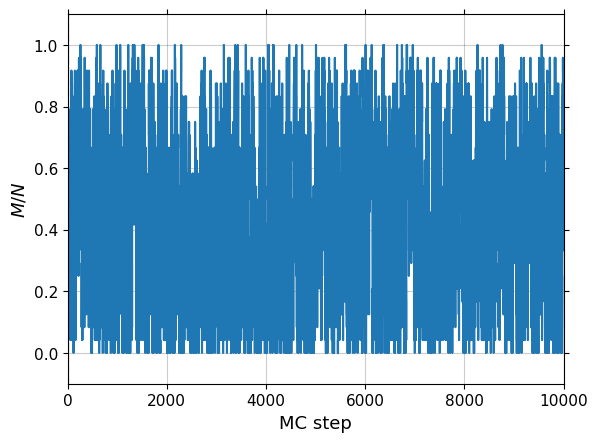

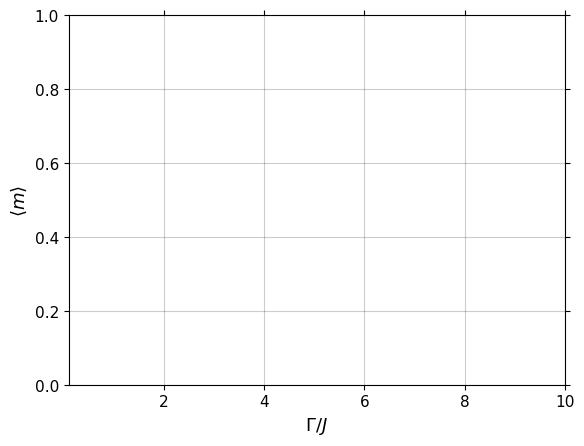

In [86]:
Nx, Ny, Nz = 4, 4, 10 # size of the lattice
J = 1

Neq = 500 # number of MC steps for equilibrium
Nsteps = 10000 # number of MC sample for average

T = [1.]
Gamma = np.linspace(0.1,10,25)


M,chi = MC_averages2(Nx, Ny, nz, J, Gamma, T, Neq, Nsteps, plot_MC = [len(Gamma)//2])

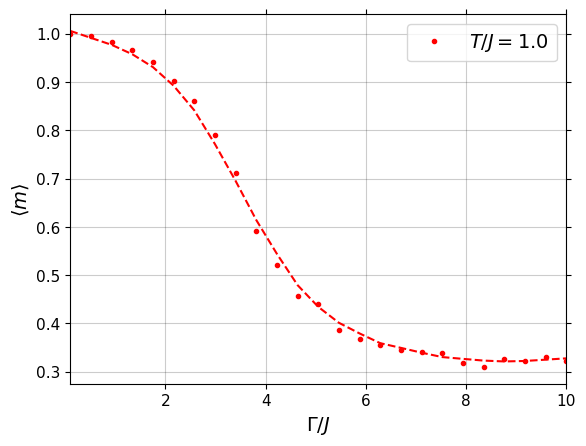

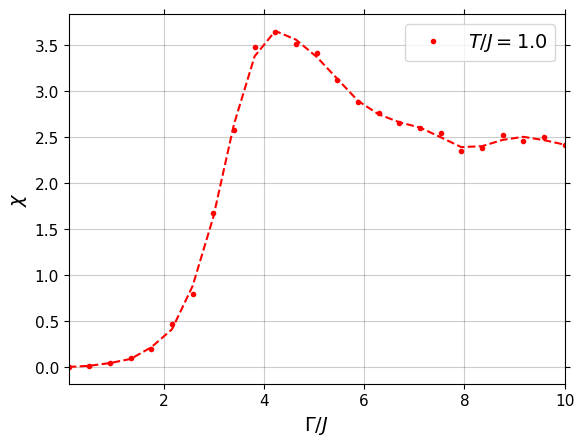

In [108]:
# Plot Mag

create_plot(r'$\Gamma/J$',r'$\langle m\rangle$',[Gamma[0],Gamma[-1]],legend_size=14,axis_size=14)

Gamma_interp = np.linspace(0,Gamma[-1],1000)

colors = ['r','b','g','o']

for i,t in enumerate(T):

    fit = savgol_filter(M[i,:],5,1)
    plt.plot(Gamma,fit,'--',color=colors[i])
    plt.plot(Gamma,M[i,:],'.',label=r'$T/J=$'+str(t),color=colors[i])

    plt.legend()

plt.savefig('Report/Plots/gamma_transition_m.pdf')

# Plot chi

create_plot(r'$\Gamma/J$',r'$\chi$',[Gamma[0],Gamma[-1]],legend_size=14,axis_size=14)

Gamma_interp = np.linspace(0,Gamma[-1],1000)

colors = ['r','b','g','o']

for i,t in enumerate(T) :
    fit = savgol_filter(chi[i,:],5,3)
    plt.plot(Gamma,fit,'--',color=colors[i])
    plt.plot(Gamma,chi[i,:],'.',label=r'$T/J=$'+str(t),color=colors[i])

    plt.legend()

plt.savefig('Report/Plots/gamma_transition_chi.pdf')

plt.show()

In [78]:
chi[0,:]

array([0.01510633, 0.08239229, 0.69225576, 2.22597048, 2.26463452,
       2.02948882, 1.83510853, 1.79429461, 1.85962849, 1.75374755])

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:36<00:00,  3.61s/it]


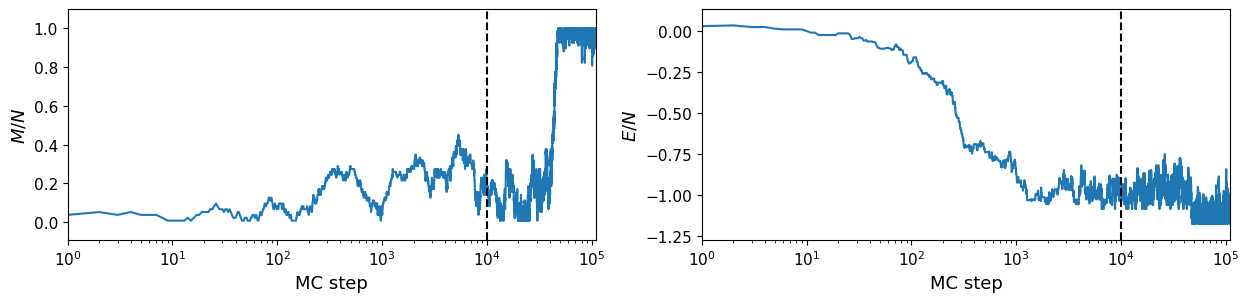

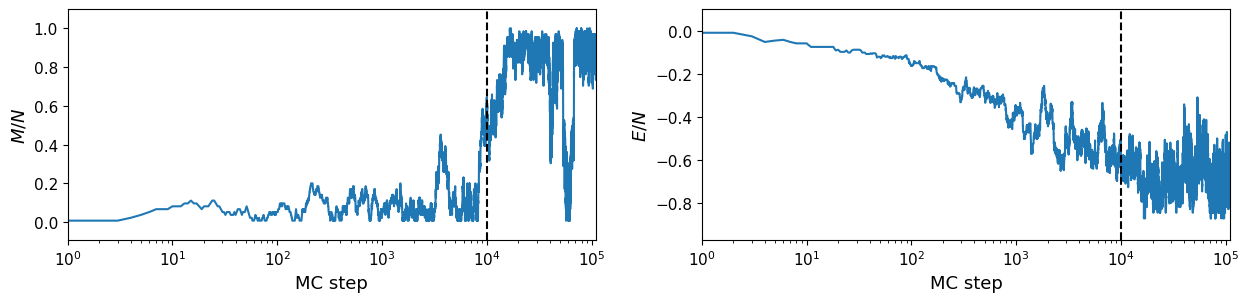

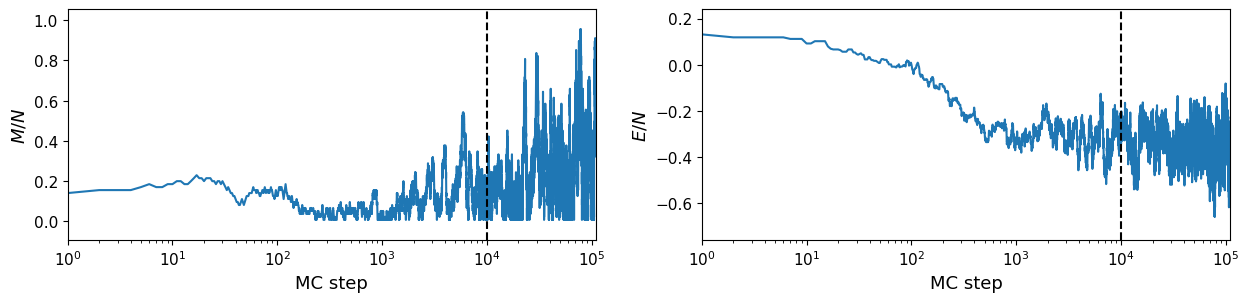

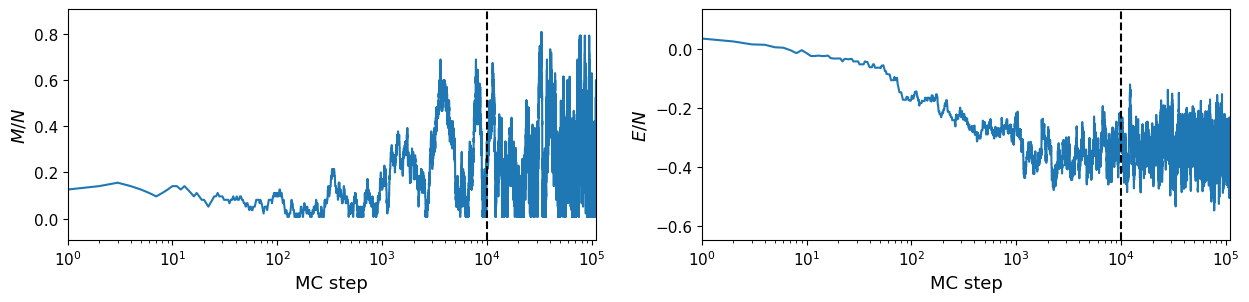

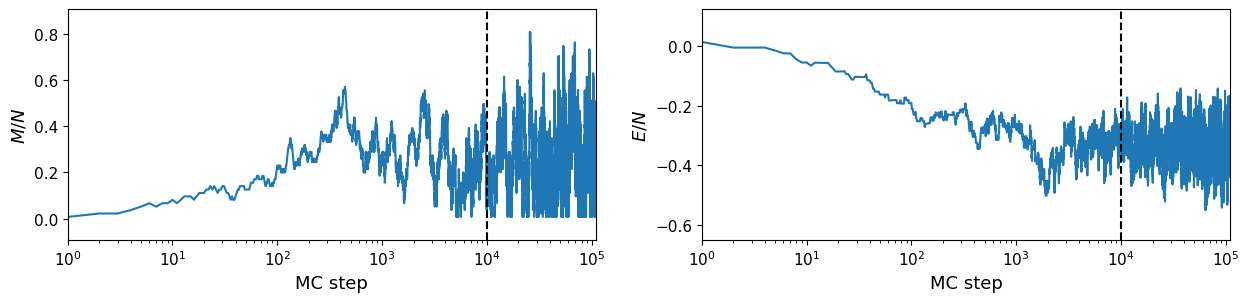

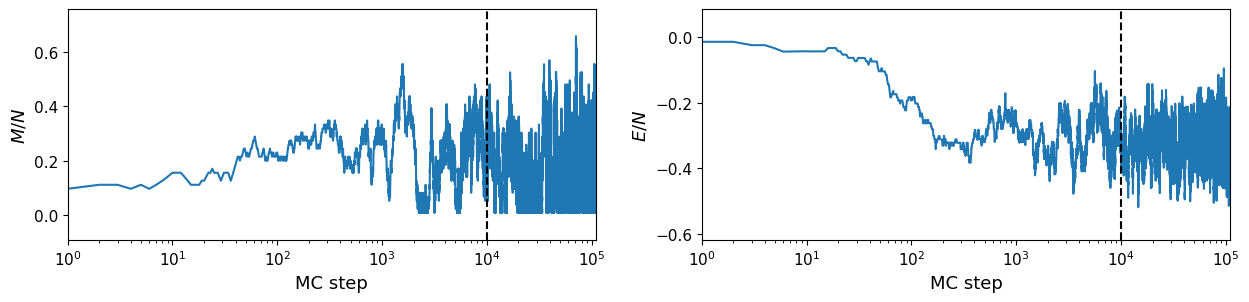

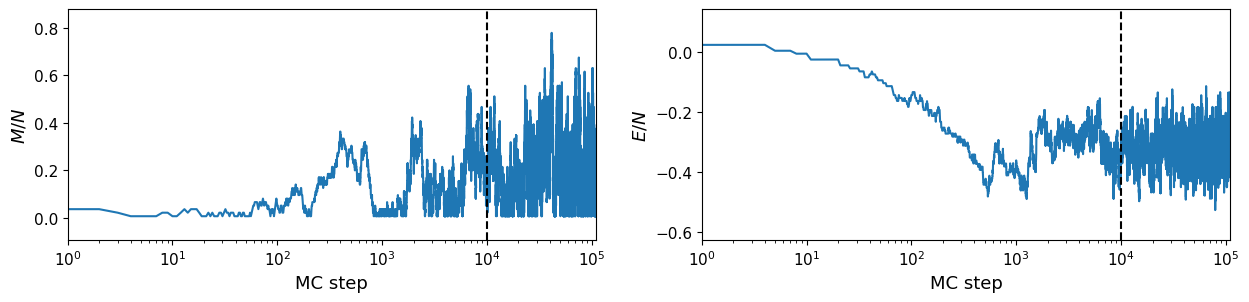

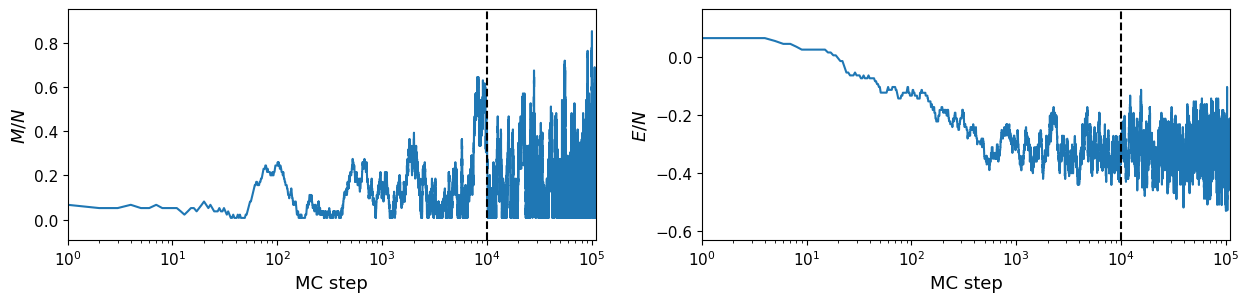

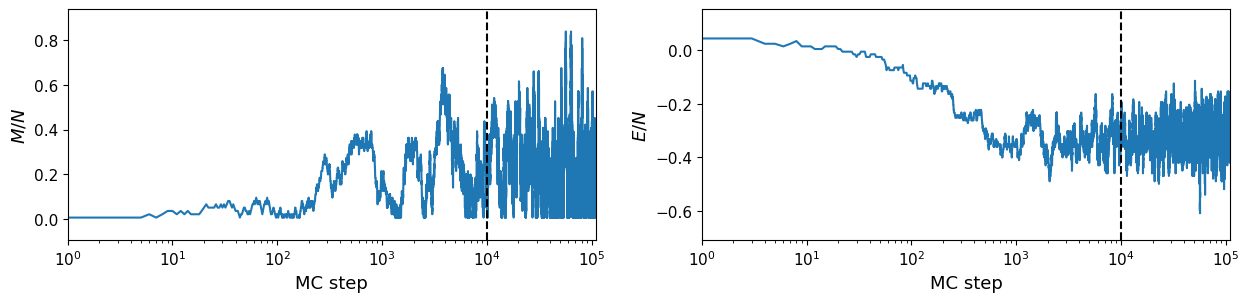

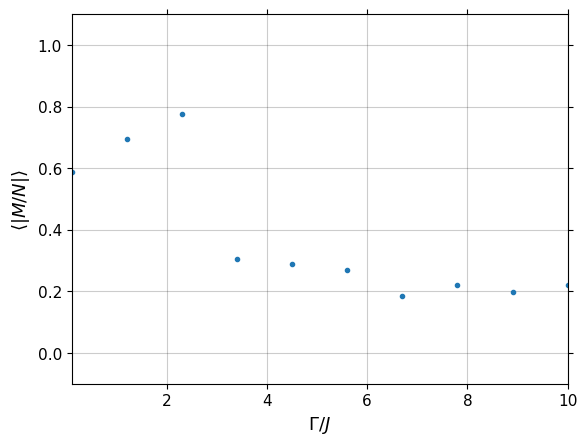

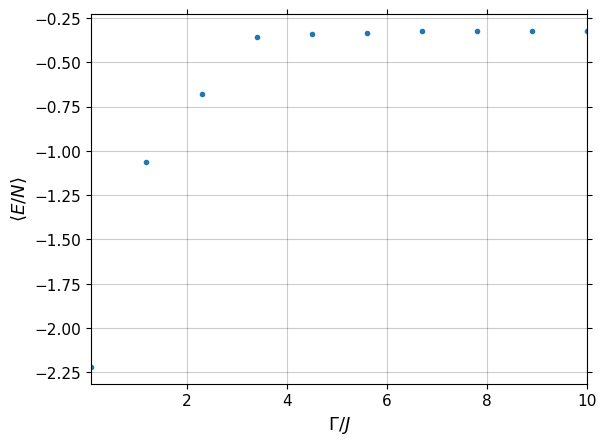

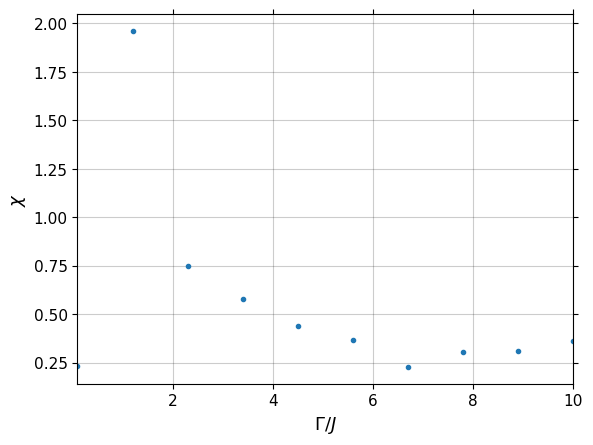

In [ ]:
Nx, Ny, Nz = 3, 3, 15 # size of the lattice
J = 1
beta = 1

Neq = 10000 # number of MC steps for equilibrium
Nsteps = 100000 # number of MC sample for average

Gamma = np.linspace(0.1,10,10)

M = np.zeros(len(Gamma))
E = np.zeros(len(Gamma))
chi = np.zeros(len(Gamma))


for i in tqdm(range(len(Gamma))) :
    gamma = Gamma[i]
    plot_MC = False
    if i > 0 : plot_MC = True
    MG,EG = MC_configurations(Nx,Ny,Nz,J,gamma,beta,Neq,Nsteps,plot_MC=plot_MC)
    M[i] = np.sum(MG)/Nsteps
    E[i] = np.sum(EG)/Nsteps
    chi[i] = (np.sum(MG**2)/Nsteps - M[i]**2)/t



create_plot(r'$\Gamma/J$',r'$\langle |M/N|\rangle$',[Gamma[0],Gamma[-1]],ylim=[-0.1,1.1],logx=False)
plt.plot(Gamma,M/(Nx*Ny*Nz),'.')

create_plot(r'$\Gamma/J$',r'$\langle E/N\rangle$',[Gamma[0],Gamma[-1]],logx=False)
plt.plot(Gamma,E/(Nx*Ny*Nz),'.')

create_plot(r'$\Gamma/J$',r'$\chi$',[Gamma[0],Gamma[-1]])
plt.plot(Gamma,chi/(Nx*Ny*Nz),'.')

plt.show()

# Transverse Ising

In [ ]:
N = 10
Ny = 10

def random_lattice(N, Ny) :

    lattice = np.array([[1 if np.random.uniform()<0.5 else -1 for i in range(N)] for j in range(Ny)])

    return lattice

def plot_lattice(lattice, N, Ny) :
    
    fig = plt.figure()
    x = np.arange(0,N,1)
    y = np.arange(0,Ny,1)

    for i in range(N) :
        for j in range(Ny) :
            if lattice[i,j] == 1 :
                color = 'r'
            else :
                color = 'b'
            plt.scatter([x[i]],[y[j]],color=color)

    plt.show()

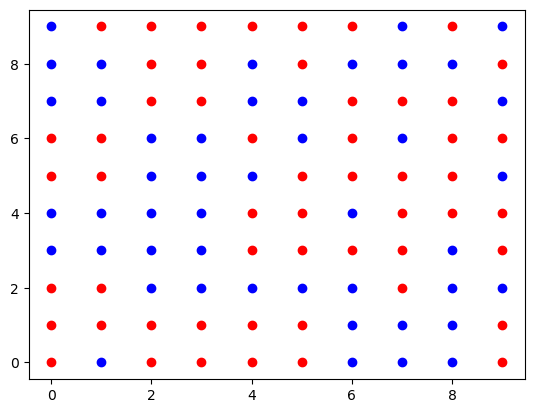

In [ ]:
plot_lattice(random_lattice(N,Ny),N,Ny)

In [ ]:
def plot_MH_sample(sample, Naccepted, Nsample, true_pdf) :

    create_plot('sample number',r'$x$',[0,len(sample)],title='Acceptance rate: '+str('{:.2f}'.format(Naccepted/Nsample)))

    plt.plot(np.arange(len(sample)),sample,marker='.')


    Nbin = 50
    x = np.linspace(0,10,10000)

    pdf = true_pdf(x)
    xmax = x[np.logical_and(pdf<1e-3,x>x[np.argmax(pdf)])][0]
    
    create_plot(r'$x$','distribution',[0,xmax])

    plt.hist(sample,bins=Nbin,density=True,histtype='step',label='MH sample')
    plt.plot(x,pdf,label='true PDF')

    plt.legend()
    plt.show()


def energy(lattice, N, Ny, g, beta):

    a = beta*g/Ny
    gamma = -np.log(np.tanh(a))

    E = 0

    lattice_periodic = np.zeros((N+1,Ny+1))
    lattice_periodic[0:N,0:Ny] = lattice
    lattice_periodic[-1,:-1] = lattice[0]
    lattice_periodic[:-1,-1] = lattice[:,0]

    for i in range(N) :
        for j in range(Ny) :

            ei =  -lattice_periodic[i,j]*(Ny*gamma/beta*lattice_periodic[i,j+1]+lattice_periodic[i+1,j])
            E += ei

    return E


def MC_step(config, N, Ny, g, beta) : # flips one spins and accept the new config with a certain probability

    candidate_lattice = np.copy(config)

    Eold = energy(candidate_lattice,N,Ny,g,beta)
    
    # flip one randomly chosen site

    a = np.random.randint(low=0,high=N)
    b = np.random.randint(low=0,high=Ny)
    candidate_lattice[a,b] = -candidate_lattice[a,b]

    # compute the new energy

    Enew = energy(candidate_lattice,N,Ny,g,beta)

    if Enew < Eold :
         return candidate_lattice

    else :

        a = np.exp(-beta*(Enew-Eold))
        
        if np.random.uniform() < a: # accept candidate if alpha>=1 or accept candidate with proba alpha if 0<alpha<1

            return candidate_lattice

        else: return config



def Monte_Carlo(N, Ny, g, beta, Nsample) :

    sample = np.zeros((Nsample,N,Ny))
    sample[0] = random_lattice(N,Ny)


    Naccepted = 0

    for i in tqdm(range(1,Nsample)):

        candidate_lattice = np.copy(sample[i-1])
        Eold = energy(candidate_lattice,N,Ny,g,beta)

        # flip one randomly chosen site

        a = np.random.randint(low=0,high=N)
        b = np.random.randint(low=0,high=Ny)
        candidate_lattice[a,b] = -candidate_lattice[a,b]

        # compute the new energy

        Enew = energy(candidate_lattice,N,Ny,g,beta)

        if Enew < Eold :
            sample[i] = np.copy(candidate_lattice)

        else :

            a = np.exp(-beta*(Enew-Eold))
        
            if np.random.uniform() < a: # accept candidate if alpha>=1 or accept candidate with proba alpha if 0<alpha<1

                sample[i] = np.copy(candidate_lattice)
                Naccepted += 1

            else: sample[i] = np.copy(sample[i-1])

        
    sample = sample[Nsample//10:] # remove beginning of the Markov chain
    
    return sample, Naccepted/Nsample



In [ ]:
Monte_Carlo(100,100,1.3,1.4,10000)

  0%|          | 0/9999 [00:00<?, ?it/s]

100%|██████████| 9999/9999 [02:32<00:00, 65.67it/s]


(array([[[ 1., -1.,  1., ..., -1., -1.,  1.],
         [-1.,  1.,  1., ..., -1., -1., -1.],
         [ 1.,  1., -1., ..., -1.,  1.,  1.],
         ...,
         [ 1., -1., -1., ..., -1.,  1.,  1.],
         [ 1.,  1., -1., ...,  1., -1.,  1.],
         [ 1.,  1., -1., ..., -1.,  1.,  1.]],
 
        [[ 1., -1.,  1., ..., -1., -1.,  1.],
         [-1.,  1.,  1., ..., -1., -1., -1.],
         [ 1.,  1., -1., ..., -1.,  1.,  1.],
         ...,
         [ 1., -1., -1., ..., -1.,  1.,  1.],
         [ 1.,  1., -1., ...,  1., -1.,  1.],
         [ 1.,  1., -1., ..., -1.,  1.,  1.]],
 
        [[ 1., -1.,  1., ..., -1., -1.,  1.],
         [-1.,  1.,  1., ..., -1., -1., -1.],
         [ 1.,  1., -1., ..., -1.,  1.,  1.],
         ...,
         [ 1., -1., -1., ..., -1.,  1.,  1.],
         [ 1.,  1., -1., ...,  1., -1.,  1.],
         [ 1.,  1., -1., ..., -1.,  1.,  1.]],
 
        ...,
 
        [[ 1.,  1.,  1., ..., -1., -1., -1.],
         [ 1.,  1.,  1., ..., -1., -1., -1.],
         [ 1.,

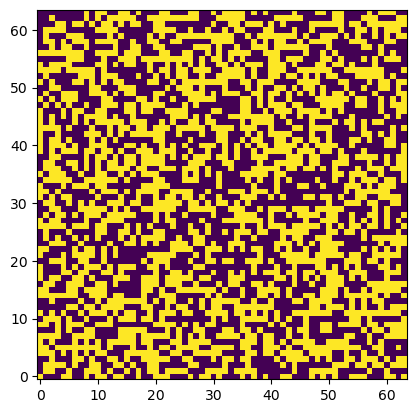

In [ ]:
N,Ny = 64,64

lattice = random_lattice(N,Ny)

ax = plt.axes()

X,Y = np.meshgrid(range(N),range(Ny))

plt.pcolormesh(X,Y,lattice)

ax.set_aspect('equal')
plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


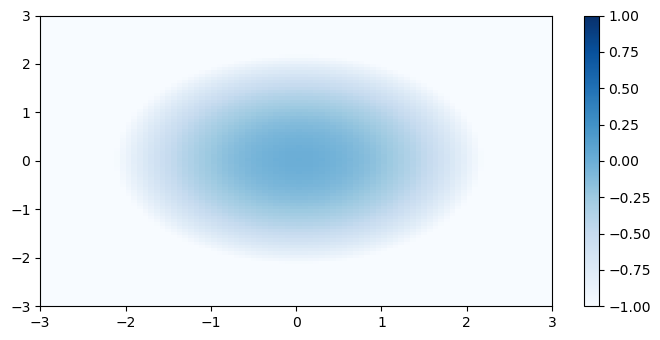

In [ ]:
import numpy as np
from matplotlib import pyplot as plt, animation
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

fig, ax = plt.subplots()
x = np.linspace(-3, 3, 91)
t = np.linspace(0, 25, 30)
y = np.linspace(-3, 3, 91)
X3, Y3, T3 = np.meshgrid(x, y, t)
sinT3 = np.sin(2 * np.pi * T3 / T3.max(axis=2)[..., np.newaxis])
G = (X3 ** 2 + Y3 ** 2) * sinT3
cax = ax.pcolormesh(x, y, G[:-1, :-1, 0], vmin=-1, vmax=1, cmap='Blues')
fig.colorbar(cax)

def animate(i):
   cax.set_array(G[:-1, :-1, i].flatten())

anim = animation.FuncAnimation(fig, animate, interval=100, frames=len(t) - 1)
#anim.save('517.gif')
plt.show()